## Processing data

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import json

In [2]:
os.chdir('./5 frame')

f = open('alphapose-results.json')

data = json.load(f)
    
f.close()


In [3]:
## Groups same frames together

data_by_frames = []
curr_frame = 0
curr_kps = []

for d in data:
    if (d['image_id'] == (str(curr_frame) + '.jpg') ):
        curr_kps.append(d)
    else:
        
        data_by_frames.append(curr_kps.copy())
        curr_kps.clear()
        curr_kps.append(d)
        curr_frame += 1

In [4]:
data_by_frames[0]

[{'image_id': '0.jpg',
  'category_id': 1,
  'keypoints': [646.8646850585938,
   376.0214538574219,
   0.751376211643219,
   646.8646850585938,
   371.26031494140625,
   0.810740053653717,
   644.484130859375,
   371.26031494140625,
   0.7047651410102844,
   644.484130859375,
   371.26031494140625,
   0.765584409236908,
   630.20068359375,
   368.8797302246094,
   0.7772585153579712,
   649.2452392578125,
   390.30487060546875,
   0.8955987095832825,
   613.5367431640625,
   397.4465637207031,
   0.8823920488357544,
   656.386962890625,
   426.0133972167969,
   0.9034599661827087,
   611.1561279296875,
   437.916259765625,
   0.8794399499893188,
   663.5286865234375,
   456.9608154296875,
   0.9188024401664734,
   618.2978515625,
   473.6247863769531,
   0.9276562929153442,
   649.2452392578125,
   461.7219543457031,
   0.8297926783561707,
   623.0590209960938,
   466.48309326171875,
   0.8240148425102234,
   675.4315185546875,
   504.57220458984375,
   0.8702268600463867,
   615.91729

In [7]:
def input_ids(frame):
    while True:
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

    left_id = int(input('Left Fencer'))
    right_id = int(input('Right Fencer'))
    skip_frames = int(input('Skip Frames'))
    return left_id, right_id, skip_frames

In [6]:
cap = cv2.VideoCapture("AlphaPose_output.mp4")

ret, frame = cap.read()

posList = []
def onMousePisteCorners(event, x, y, flags, param):
   global posList
   if event == cv2.EVENT_LBUTTONDOWN:
        posList.append((x, y))
cv2.imshow('WindowName', frame)
cv2.setMouseCallback('WindowName', onMousePisteCorners)

while(1):
    if cv2.waitKey(10) & 0xFF==ord('q'):
        cv2.destroyAllWindows()
        break

pisteLines = {}
pisteLineIdentifiers = ['middleLines', 'leftEngardeLine', 'rightEngardeLine', 'leftWarningLine', 'rightWarningLine', 'leftEndLine', 'rightEndLine']
curr = 0
ptList = []

def onMousePisteLines(event, x, y, flags, param):
    global pisteLines
    global pisteLineIdentifiers
    global curr
    global ptList
    if event == cv2.EVENT_LBUTTONDOWN:
        ptList.append((x, y))
    elif event == cv2.EVENT_RBUTTONDOWN:
        print(ptList)
        avg_x = (ptList[0][0] + ptList[1][0]) / 2
        avg_y = (ptList[0][1] + ptList[1][1]) / 2
        pisteLines[pisteLineIdentifiers[curr]] = (avg_x, avg_y)
        curr += 1
        ptList.clear()

cv2.imshow('WindowName', frame)
cv2.setMouseCallback('WindowName', onMousePisteLines)

while(1):
    if cv2.waitKey(10) & 0xFF==ord('q'):
        cv2.destroyAllWindows()
        break
        
cap.release()
cv2.destroyAllWindows()

[(977, 547), (982, 639)]
[(718, 552), (692, 642)]
[(1235, 545), (1269, 633)]
[(318, 558), (249, 649)]
[(1628, 537), (1710, 622)]


In [8]:
def check_point_pos_relative_to_line(point, line_pt1, line_pt2):
    v1 = (line_pt2[0]-line_pt1[0], line_pt2[1]-line_pt1[1])   # Vector 1
    v2 = (line_pt2[0]-point[0], line_pt2[1]-point[1])   # Vector 2
    xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product (magnitude)
    # If xp > 0, point is above if Xp < 0, point is below else is on the line
    return xp

def average_keypoints(keypoints, confidence_threshold):
    total_considered = 0
    total_y = 0
    total_x = 0
    counter = 0
    kx = 0
    ky = 0
    for count, kp in enumerate(keypoints):
        if (count % 3 == 0):
            kx = kp
        elif (count % 3 == 1):
            ky = kp
        else:
            if kp > confidence_threshold:
                total_considered += 1
                total_y += ky
                total_x += kx
            kx = 0
            ky = 0
    
    average_y = total_y / total_considered
    average_x = total_x / total_considered
    
    return average_x, average_y

def check_point_in_box(point, box_corners):
    # box_corners is an array of points with box coordinates of this order topleft, topright, bottomleft, bottom right
    relative_to_top_line = check_point_pos_relative_to_line(point, box_corners[0], box_corners[1])
    relative_to_bottom_line = check_point_pos_relative_to_line(point, box_corners[2], box_corners[3])
    relative_to_left_line = check_point_pos_relative_to_line(point, box_corners[0], box_corners[2])
    relative_to_right_line = check_point_pos_relative_to_line(point, box_corners[1], box_corners[3])
    return (relative_to_top_line <= 0) and (relative_to_bottom_line >= 0) and (relative_to_left_line >= 0) and (relative_to_right_line <= 0)

# Function to loop through each person detected and render
def loop_through_people_in_piste(keypoints_with_scores, piste_corners):
    personList = []
    for kps in keypoints_with_scores:
        person = kps['keypoints']
        ## x y
        right_ankle = (person[-3], person[-2])
        left_ankle = (person[-6], person[-5])
        right_in = check_point_in_box(right_ankle, piste_corners)
        left_in = check_point_in_box(left_ankle, piste_corners)
        if left_in or right_in:
            personList.append(person)
            
    return personList

In [9]:
import math

def distCalc(pt1, pt2):
    dis = math.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)
    return dis

def calc_dist_from_4m(fencer):
    # Negative if to the left of engarde, positive otherwise
    if (fencer[0] < pisteLines['leftEngardeLine'][0]):
        # Left side
        distFromLeftEGLine = leftEngardeToLeftWarning * (fencer[0] - pisteLines['leftEngardeLine'][0])
        return distFromLeftEGLine - 200
    elif (fencer[0] < pisteLines['middleLines'][0]):
        distFromMidLine = leftEnGardeToMid * (fencer[0] - pisteLines['middleLines'][0])
        return distFromMidLine
    elif (fencer[0] < pisteLines['rightEngardeLine'][0]):
        distFromMidLine = rightEnGardeToMid * (fencer[0] - pisteLines['middleLines'][0])
        return distFromMidLine
    else:
        distFromRightEGLine = rightEngardeToRightWarning * (fencer[0] - pisteLines['rightEngardeLine'][0])
        return 200 + distFromRightEGLine

In [10]:
cap = cv2.VideoCapture("AlphaPose_output.mp4")

ret, frame = cap.read()

left_id, right_id, skip_frames = input_ids(frame)

print(left_id, right_id)

left_kp = []
right_kp = []

frame_count = 0
for d in data_by_frames[frame_count]:
    if (d['idx'] == left_id):
        left_kp.append(average_keypoints(d['keypoints'], 0.1))
    elif(d['idx'] == right_id):
        right_kp.append(average_keypoints(d['keypoints'], 0.1))
    else:
        pass

frame_count += 1     
left_found = False
right_found = False
left_no_find_count = 0
right_no_find_count = 0
crossed_count = 0
skip_frames = -1

while(True):
    ret, frame = cap.read()
    
    # To skip frames, indicate -1, the program will take the last known position of left and right until skip frames is -1 again
    if (skip_frames == -1):
        pass
    else:
        left_kp.append(left_kp[-1])
        right_kp.append(right_kp[-1])
        skip_frames -= 1
        if (skip_frames == 0):
            left_no_find_count = 0
            right_no_find_count = 0
            crossed_count = 0
            left_id, right_id, skip_frames = input_ids(frame)
        frame_count += 1
        continue
        
    
    for d in data_by_frames[frame_count]:
        if (d['idx'] == left_id):
            left_kp.append(average_keypoints(d['keypoints'], 0.1))
            left_found = True
            left_no_find_count = 0
        elif(d['idx'] == right_id):
            right_kp.append(average_keypoints(d['keypoints'], 0.1))
            right_found = True
            right_no_find_count = 0
        else:
            pass
        
    if not left_found:
        left_kp.append(left_kp[-1])
        left_no_find_count += 1
        if (left_no_find_count == 30):
            left_no_find_count = 0
            right_no_find_count = 0
            crossed_count = 0
            left_id, right_id, skip_frames = input_ids(frame)
            
    
    if not right_found:
        right_kp.append(right_kp[-1])
        right_no_find_count += 1
        if (right_no_find_count == 30):
            left_no_find_count = 0
            right_no_find_count = 0
            crossed_count = 0
            left_id, right_id, skip_frames = input_ids(frame)
            
    if (left_kp[-1][0] > right_kp[-1][0]):
        ## Crossed
        crossed_count += 1
        if (crossed_count == 30):
            left_no_find_count = 0
            right_no_find_count = 0
            crossed_count = 0
            left_id, right_id, skip_frames = input_ids(frame)
            
    left_found = False
    right_found = False
    
    frame_count += 1
    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

Left Fencer1
Right Fencer2
Skip Frames-1
1 2
Left Fencer1
Right Fencer2
Skip Frames-1
Left Fencer15
Right Fencer1
Skip Frames-1
Left Fencer23
Right Fencer1
Skip Frames-1
Left Fencer51
Right Fencer1
Skip Frames-1
Left Fencer51
Right Fencer-1
Skip Frames-1
Left Fencer51
Right Fencer-1
Skip Frames-1
Left Fencer51
Right Fencer52
Skip Frames-1
Left Fencer52
Right Fencer51
Skip Frames-1
Left Fencer62
Right Fencer51
Skip Frames-1
Left Fencer62
Right Fencer71
Skip Frames-1
Left Fencer71
Right Fencer90
Skip Frames-1
Left Fencer134
Right Fencer90
Skip Frames-1
Left Fencer134
Right Fencer140
Skip Frames-1
Left Fencer157
Right Fencer140
Skip Frames-1
Left Fencer157
Right Fencer-1
Skip Frames-1
Left Fencer157
Right Fencer-1
Skip Frames-1
Left Fencer-1
Right Fencer-1
Skip Frames1590
Left Fencer-1
Right Fencer175
Skip Frames-1
Left Fencer-1
Right Fencer175
Skip Frames-1
Left Fencer191
Right Fencer175
Skip Frames-1
Left Fencer-1
Right Fencer175
Skip Frames-1
Left Fencer199
Right Fencer175
Skip Frames-

IndexError: list index out of range

In [11]:
left_fencer = left_kp
right_fencer = right_kp

In [12]:
leftEnGardeToMid = 200 / distCalc(pisteLines['middleLines'], pisteLines['leftEngardeLine'])
rightEnGardeToMid = 200 / distCalc(pisteLines['middleLines'], pisteLines['rightEngardeLine'])
leftEngardeToLeftWarning = 300 / distCalc(pisteLines['leftEngardeLine'], pisteLines['leftWarningLine'])
rightEngardeToRightWarning = 300 / distCalc(pisteLines['rightEngardeLine'], pisteLines['rightWarningLine'])

left_dist = []
for coord in left_fencer:
    left_dist.append(calc_dist_from_4m(coord))
    
right_dist = []
for coord in right_fencer:
    right_dist.append(calc_dist_from_4m(coord))
    
dist_bw_fencers = []
for i in range(len(left_dist)):
    dist_bw_fencers.append(((right_dist[i] + 700) - (left_dist[i] + 700)))

vel_left = []
for i in range(len(left_dist) - 1):
    vel_left.append((left_dist[i + 1] - left_dist[i]))
    
vel_right = []
for i in range(len(right_dist) - 1):
    vel_right.append((right_dist[i + 1] - right_dist[i]))

In [13]:
time_in_seconds = [(i+1) / 30 for i in range(len(dist_bw_fencers))]

Text(0.5, 1.0, 'Right Velocity')

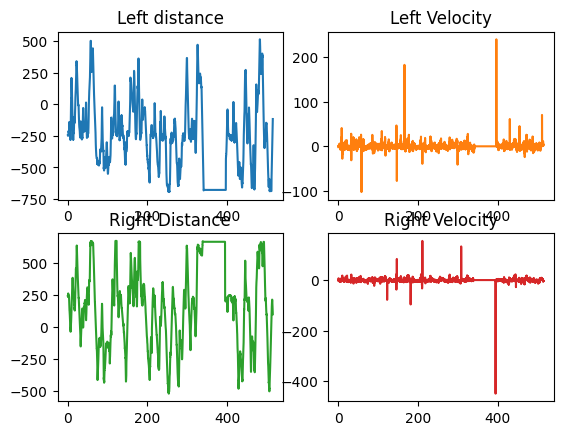

In [14]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(time_in_seconds, left_dist)
axs[0, 0].set_title('Left distance')
axs[0, 1].plot(time_in_seconds[1:], vel_left, 'tab:orange')
axs[0, 1].set_title('Left Velocity')
axs[1, 0].plot(time_in_seconds, right_dist, 'tab:green')
axs[1, 0].set_title('Right Distance')
axs[1, 1].plot(time_in_seconds[1:], vel_right, 'tab:red')
axs[1, 1].set_title('Right Velocity')

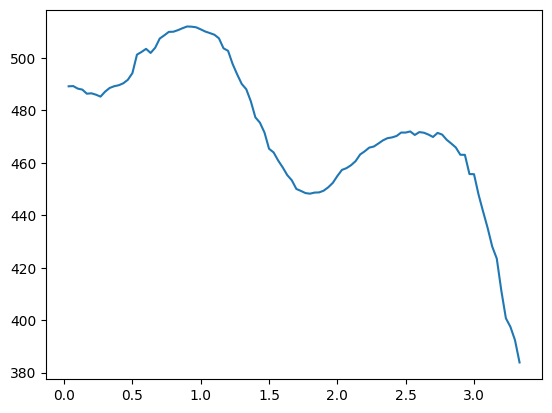

In [78]:
plt.plot(time_in_seconds[0:100], dist_bw_fencers[0:100])

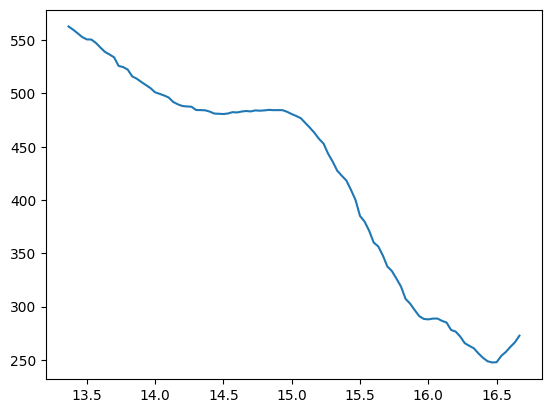

In [77]:
plt.plot(time_in_seconds[400:500], dist_bw_fencers[400:500])

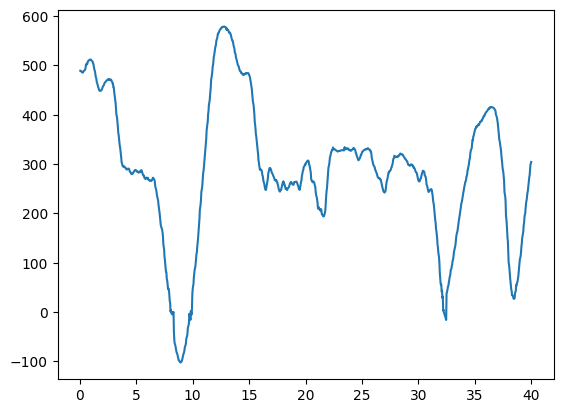

In [79]:
plt.plot(time_in_seconds[0:1200], dist_bw_fencers[0:1200])

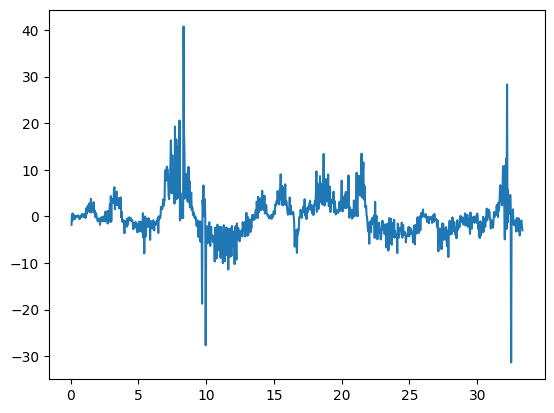

In [45]:
plt.plot(time_in_seconds[1:1000], vel_left[0:999])

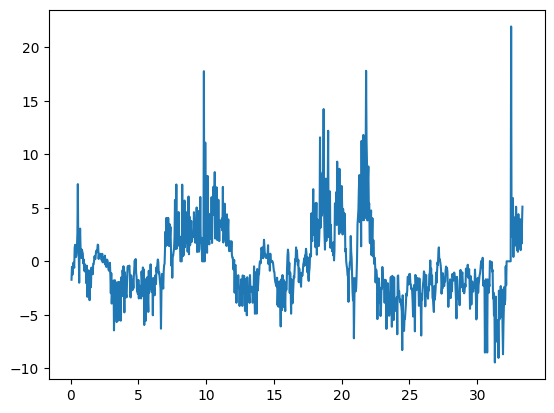

In [49]:
plt.plot(time_in_seconds[1:1000], vel_right[0:999])

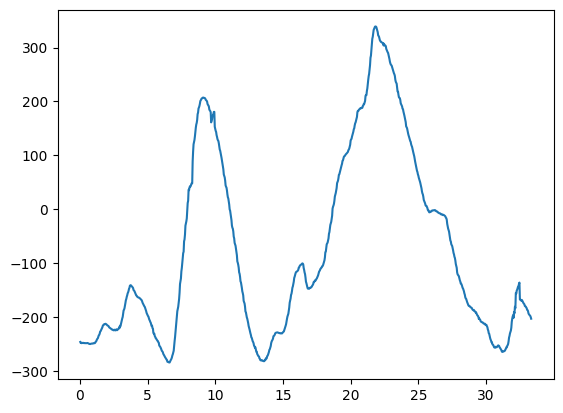

In [47]:
plt.plot(time_in_seconds[0:1000], left_dist[0:1000])

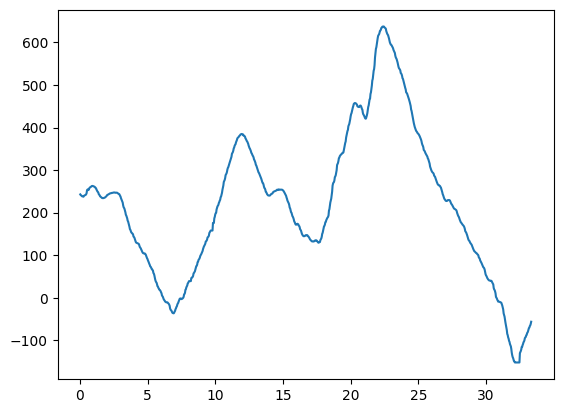

In [48]:
plt.plot(time_in_seconds[0:1000], right_dist[0:1000])

## Old way of calculating distance

In [50]:
left_fencer2 = []
right_fencer2 = []

for frame_data in data_by_frames:
    
    # Filter fencers and Render keypoints 
    people = loop_through_people_in_piste(frame_data, posList)
    
    # Check left and right fencer
    if (len(people) == 0):
        left_fencer2.append(left_fencer2[-1])
        right_fencer2.append(right_fencer2[-1])
    elif (len(people) == 1):
        fencer0 = people[0]
        avg0_x, avg0_y = average_keypoints(fencer0, 0.1)
        
        left_last = left_fencer2[-1]
        right_last = right_fencer2[-1]
        
        if (avg0_x - right_last[0])**2 < (avg0_x - left_last[0])**2:
            right_fencer2.append([avg0_x, avg0_y])
            left_fencer2.append(left_last)
        else:
            left_fencer2.append([avg0_x, avg0_y])
            right_fencer2.append(right_last)
    else:
        fencer0 = people[0]
        fencer1 = people[1]

        avg0_x, avg0_y = average_keypoints(fencer0, 0.1)
        avg1_x, avg1_y = average_keypoints(fencer1, 0.1)

        if (avg0_x < avg1_x):
            left_fencer2.append([avg0_x, avg0_y])
            right_fencer2.append([avg1_x, avg1_y])
        else:
            right_fencer2.append([avg0_x, avg0_y])
            left_fencer2.append([avg1_x, avg1_y])
    

In [51]:
left_dist2 = []
for coord in left_fencer2:
    left_dist2.append(calc_dist_from_4m(coord))
    
right_dist2 = []
for coord in right_fencer2:
    right_dist2.append(calc_dist_from_4m(coord))
    
dist_bw_fencers2 = []
for i in range(len(left_dist2)):
    dist_bw_fencers2.append(((right_dist2[i] + 700) - (left_dist2[i] + 700)))

vel_left2 = []
for i in range(len(left_dist2) - 1):
    vel_left2.append((left_dist2[i + 1] - left_dist2[i]))
    
vel_right2 = []
for i in range(len(right_dist2) - 1):
    vel_right2.append((right_dist2[i + 1] - right_dist2[i]))

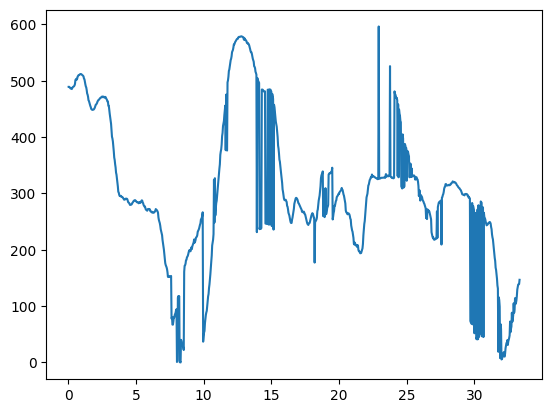

In [52]:
plt.plot(time_in_seconds[0:1000], dist_bw_fencers2[0:1000])

In [63]:
data_by_frames[435]

[{'image_id': '435.jpg',
  'category_id': 1,
  'keypoints': [985.2959594726562,
   579.5731811523438,
   0.4714282155036926,
   980.6446533203125,
   574.921875,
   0.4560418426990509,
   987.62158203125,
   577.2474975585938,
   0.4835171699523926,
   973.6676635742188,
   581.8988037109375,
   0.9185792803764343,
   1001.5755004882812,
   581.8988037109375,
   0.9171244502067566,
   959.7137451171875,
   619.1093139648438,
   0.8647670745849609,
   1017.8551025390625,
   612.1323852539062,
   0.8896070122718811,
   945.759765625,
   665.6224365234375,
   0.8714138865470886,
   1036.4603271484375,
   653.994140625,
   0.9423593878746033,
   920.1776123046875,
   656.31982421875,
   0.9213818907737732,
   1062.0426025390625,
   637.7145385742188,
   0.9238703846931458,
   969.016357421875,
   684.2276611328125,
   0.8324132561683655,
   1013.2037963867188,
   684.2276611328125,
   0.8377798795700073,
   979.4818115234375,
   769.1141357421875,
   0.1409669816493988,
   1095.76452636718

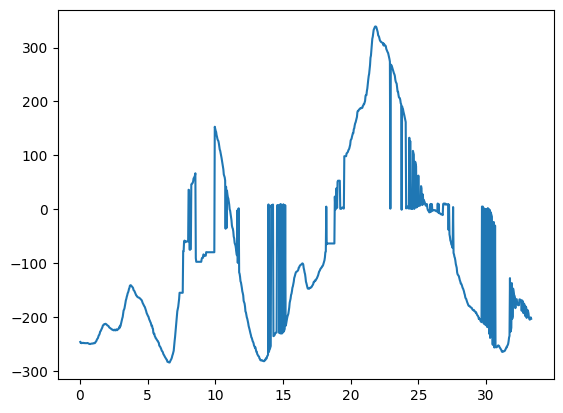

In [64]:
plt.plot(time_in_seconds[0:1000], left_dist2[0:1000])

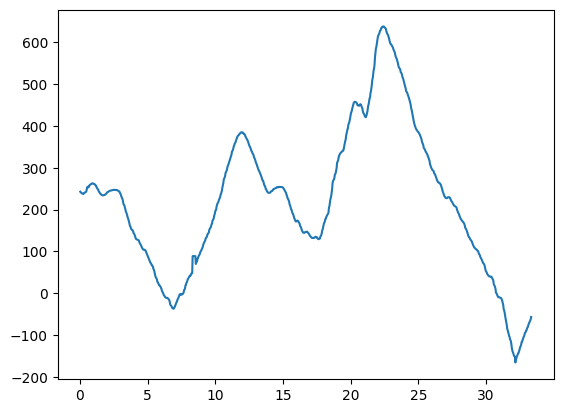

In [54]:
plt.plot(time_in_seconds[0:1000], right_dist2[0:1000])